# PyTorch Transformer

Полезные материалы:
- [Attention Is All You Need (Paper)](https://arxiv.org/abs/1706.03762)
- [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- [Sequence-to-Sequence Modeling with nn.Transformer and TorchText](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)
- [How To Code The Transformer in PyTorch](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec#1b3f)
- [PyTorch's nn.Transformer (article)](https://andrewpeng.dev/transformer-pytorch/)



Реккурентная нейронная сеть не может обрабатывать очень длинные последовательности

<img src="https://miro.medium.com/max/1280/1*w2OJ4jfjxmlcqu6k4BdgrA.gif" width="600">



## Архитектура модели

<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png?raw=true" width="300">

<!-- ## Размерности

Чтобы было легче понять модель, для начала разберемся с размерностями тензоров. Размерности зафиксируем в соответствии с размерностями тензоров в PyTorch's реализации Трансформера. 

- src: (S, N, E) = **(source sequence len, batch size, feature number)**
- tgt: (T, N, E) = **(target sequence len, batch size, feature number)**
- tgt_mask: (T, T) = **(target sequence len, target sequence len)**
- src_key_padding_mask: (N, S) = **(batch size, source sequence len)**
- tgt_key_padding_mask: (N, T) = **(batch size, target sequence len)**
- memory_key_padding_mask: (N, S) = **(batch size, source sequence len)**

### Пример
```
SRC_LEN = 50
TGT_LEN = 40
BATCH_SIZE = 100
NUM_FEATURES = 512
``` -->


In [35]:
import math
import torch
import torch.nn as nn
import numpy as np

from matplotlib import pyplot as plt
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F

## Embedding and Softmax

<img src="images/input_embeddings.png" width="1000">

Модель преобразует последовательность объектов (слов) в последовательность векторов, обучая эмбеддинги объектов (слов). Данные эмбеддинги имеют размерность $d_{model}$.

Чтобы конвертировать выходы модели в объекты используется линейный слой с функцией активации `softmax`. 

В модели используются общие эмбеддинги для входного и выходного слоев. В эмбеддинг слое веса домножаются на $\sqrt{d_{model}}$.

In [36]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

## Positional Encoding

<img src="images/lstm.png" width="1000">

В нейронной сети Трансформер информация о позиции элемента в последовательности передается явно в модель. Это делается добавлением к эмбеддингов слов векторов (positional encodings), кодирующих позицию элемента в исходной последовательносте. Данные вектора имеют туже размерность, что и размерность эмбеддингов ($d_{model}$).

<img src="images/transformer.png" width="1000">

- Какие варианты добавления информации о позиции объекта вы можете предложить?
- Обсудить преимущетсва и недостатки.




В трансформере данные вектора вычисляются по формуле:

$$
\mathbb{PE}(pos, 2i+0) = sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right) \\
\mathbb{PE}(pos, 2i+1) = sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

В данной формуле:
- $pos$ - позиция элемента в последовательности
- $i$ - номер размерности
- $d_{model}$ - размерность эмбеддингов

Каждая размерность в $\mathbb{PE}$ образует синусоиду. Периоды синусоид образуют геометрическую прогрессию.

После сложения эмбеддингов и $\mathbb{PE}$-векторов в оригинальной работе применяется дропаут с $p=0.1$.

In [37]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        y = self.pe[:, :x.size(1)]
        y = y.requires_grad_()
        x = x + y
        return self.dropout(x)

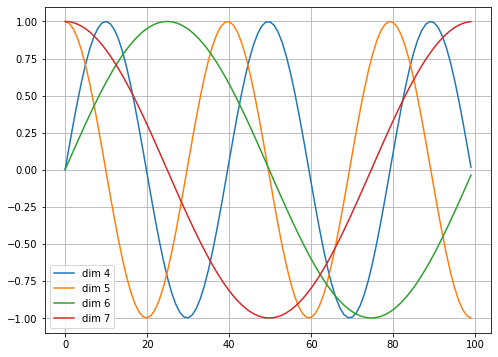

In [38]:
plt.figure(figsize=(8, 6))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.grid()
plt.show()

## Self-Attention

<img src="images/self_attention.png" width="1000">


## Self-Attention

<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png?raw=true" width="150">


Self-attention является важнейшей частью архитектуры трансформер. Это функциональное преобразование представляетс собой отображение векторов Q(ery), K(ey), и V(alues) во взвешенную сумму векторов V, c коэффициентами, зависящими от Q и K. 

Self-attention вычисляется по формуле. 

$$
Attention(Q, K, V) = softmax \left(\frac{Q K^\top}{\sqrt{d_k}}\right)V
$$

In [39]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

## Multi-Head Attention

<img src="images/multi_head_attention.png" width="1000">

<img src="images/multi_head_attention_2.png" width="1000">


## Multi-Head Attention

Усовершенствованным Self-attention является Multi-head attention. В данном механизме информация из различных подпространств признакового пространства аккумулируется разными механизмами внимания.  

$$
MultiHead(Q, K, V) = Concat(head_1, \dots, head_h)W^O\\
head_i = Attention(QW^Q_i, KW^K_i, VW^V_i)
$$ 

В данном выражении параметры слоя:
- $W^Q_i \in \mathbb{R}^{d_{model} \times d_q}$
- $W^K_i \in \mathbb{R}^{d_{model} \times d_k}$
- $W^V_i \in \mathbb{R}^{d_{model} \times d_v}$
- $W^O \in \mathbb{R}^{hd_v \times d_{model}}$

В работе использовались следующие размерности. 

- $h = 8$ - количество  "голов" механизма внимания
- $d_k = d_v = \frac{d_{model}}{h} = 64$ 

<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png?raw=true" width="300">

In [40]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k

        query = self.linear_q(query)
        query = query.reshape(nbatches, -1, self.h, self.d_k).transpose(1, 2)

        key = self.linear_k(key)
        key = key.reshape(nbatches, -1, self.h, self.d_k).transpose(1, 2)

        value = self.linear_v(value)
        value = value.reshape(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, _ = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).reshape(nbatches, -1, self.h * self.d_k)
        return self.linear_o(x)

## Position-wise Feed-Forward Networks

В дополнение к механизму внимания, каждый блок в Трансформере также содержит полносвязанные слои, которая примяняется отдельно к каждому элементу последовательности. 

$$
FeedForwardNetwork(x) = linear(ReLU(linear(x)))
$$

В статье $d_{model} = 512$ и $d_{ff} = 2048$.

In [67]:
class PositionwiseFeedForward(nn.Module):
    "Implements FeedForwardNetwork equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Layer Norm

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png?raw=true" width="300">

Нормализация ограничивает норму, делает процесс сходимости более стабильным и быстрым

<img src="images/layer_normalization.png" width="1000">

In [70]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        #print(x.shape)
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

## Encoder

<img src="images/residual_connection.png" width="1000">

Реализуем Encoder модели  Transformer. 

In [71]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

<img src="images/feed_forward.png" width="1000">

In [44]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, h, d_model, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn    = MultiHeadedAttention(h, d_model)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        sublayer = [SublayerConnection(d_model, dropout) for i in range(2)]
        self.sublayer = nn.ModuleList(sublayer)

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [45]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, h, d_model, d_ff, dropout, num_layers):
        super(Encoder, self).__init__()
        layers = [EncoderLayer(h, d_model, d_ff, dropout) 
                    for i in range(num_layers)]
        self.layers = nn.ModuleList(layers)
        self.norm = LayerNorm(d_model)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Decoder

<img src="images/decoder_1.png" width="1000">

Реализуем Decoder модели Transformer. 

In [46]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, h, d_model, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn    = MultiHeadedAttention(h, d_model)
        self.src_attn     = MultiHeadedAttention(h, d_model)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        sublayer = [SublayerConnection(d_model, dropout) for i in range(3)]
        self.sublayer     = nn.ModuleList(sublayer)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [47]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, h, d_model, d_ff, dropout, num_layers):
        super(Decoder, self).__init__()
        layers = [DecoderLayer(h, d_model, d_ff, dropout) 
                  for i in range(num_layers)]
        self.layers = nn.ModuleList(layers)
        self.norm = LayerNorm(d_model)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

## Transformer

Соберем все написанные модули в Трансформер согласно схеме. 

<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png?raw=true" width="300">

In [48]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, h=2, d_model=512,
                 d_ff=2048, dropout=0.1, num_layers=2):
        super(Transformer, self).__init__()
        self.encoder = Encoder(h, d_model, d_ff, dropout, num_layers)
        self.decoder = Decoder(h, d_model, d_ff, dropout, num_layers) 
        enc_pos = PositionalEncoding(d_model, dropout)
        dec_pos = PositionalEncoding(d_model, dropout)
        enc_emb = Embeddings(d_model, src_vocab)
        dec_emb = Embeddings(d_model, tgt_vocab)
        self.src_embed = nn.Sequential(enc_emb, enc_pos)
        self.tgt_embed = nn.Sequential(dec_emb, dec_pos)
        self.proj = nn.Linear(d_model, tgt_vocab)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        x = self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
        x = self.logsoftmax(self.proj(x))
        return x
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

<img src="images/result_model.png" width="1000">

## Синтетические данные

Сгенерируем синтетические модельные данные для обучения модели. 

Нам потребуется маскировать переведенные слова, чтобы модель не подсматривала в область, которую она предсказывает. Для этого домножим маску механизма внимания на нижнюю треугольную единичную матрицу.

In [72]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).int()
    return subsequent_mask == 0

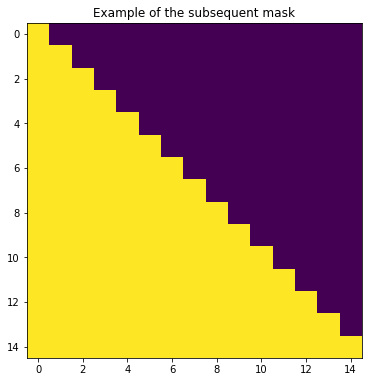

In [73]:
plt.figure(figsize=(6, 8))
plt.title("Example of the subsequent mask")
plt.imshow(subsequent_mask(15))
plt.show()

In [51]:
class SynthDataset(Dataset):
    def __init__(self, size, vocab_size=11, max_length=10, pad=0):
        data = torch.from_numpy(np.random.randint(1, vocab_size, size=(size, max_length)))
        data[:, 0] = 1
        self.data = data
        self.pad = pad
      
    def __getitem__(self, index):
        pad      = self.pad
        data     = self.data[index]
        src      = data
        tgt      = data[:-1]
        tgt_y    = data[1:]
        tgt_mask = self.make_std_mask(tgt, pad)
        n_tokens = (tgt_y != pad).sum()
        src_mask = (src != pad).unsqueeze(0)

        return src, src_mask, tgt, tgt_mask, tgt_y, n_tokens
  

    def __len__(self):
        return len(self.data)

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

In [52]:
test_dataset = SynthDataset(1000)

data = next(iter(test_dataset))
data

(tensor([ 1,  6,  6, 10,  2,  8,  5,  3, 10,  3]),
 tensor([[True, True, True, True, True, True, True, True, True, True]]),
 tensor([ 1,  6,  6, 10,  2,  8,  5,  3, 10]),
 tensor([[ True, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True]]),
 tensor([ 6,  6, 10,  2,  8,  5,  3, 10,  3]),
 tensor(9))

In [53]:
test_loader       = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
train_loader      = DataLoader(test_dataset, batch_size=32)

In [54]:
batch = next(iter(test_loader))

In [55]:
for i in batch:
    print(i.shape)

torch.Size([32, 10])
torch.Size([32, 1, 10])
torch.Size([32, 9])
torch.Size([32, 9, 9])
torch.Size([32, 9])
torch.Size([32])


Проверим, что наша модель запускается на сгенерированных данных.

In [56]:
d_model = 512
d_ff    = 2048
num_layers = 2
h = 2

src_vocab = tgt_vocab = 11


In [57]:
model = Transformer(src_vocab, tgt_vocab, h=h, d_model=d_model,
         d_ff=d_ff, dropout=0.1, num_layers=num_layers)

src, src_mask, tgt, tgt_mask, tgt_y, n_tokens = batch       
model_answers = model(src, tgt, src_mask, tgt_mask)

In [58]:
model_answers.size()

torch.Size([32, 9, 11])

In [59]:
model

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linear_q): Linear(in_features=512, out_features=512, bias=True)
          (linear_k): Linear(in_features=512, out_features=512, bias=True)
          (linear_v): Linear(in_features=512, out_features=512, bias=True)
          (linear_o): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Drop

## Learning rate schedule

Обучение трансформера вещь достаточно специфичная, поэтому стоит учесть все детали. В частности, одной из таких деталей является политика изменения learning rate.

Предлагается обновлять learning_rate согласно формуле. 

$$
lrate = d_{model}^{-0.5} \cdot \min(step\_num^{ - 0.5}, step\_num \cdot warmup\_steps^{- 1.5})
$$

Т.е. $lrate$ возрастает линейно в течение $warmup\_steps$ шагов, а затем убывает.

В статье, $warmup\_steps = 4000$.
 

In [60]:
# https://stackoverflow.com/questions/65343377/adam-optimizer-with-warmup-on-pytorch

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.model_size = model_size
        self._rate = 0
    
    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}
    
    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.
        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict) 
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5))) 

Посмотрим на графике, как изменяется learning_rate.

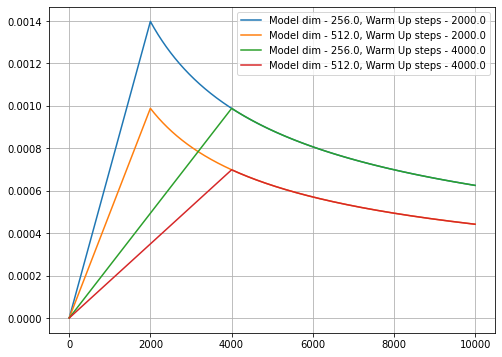

In [61]:
plt.figure(figsize=(8, 6))
for warm_up in [2000., 4000.]:
    for model_dim in [256., 512.]:
        sch = NoamOpt(model_dim, warm_up, optimizer=None)

        x = list(range(1, 10000))
        y = [sch.rate(i) for i in x]
        plt.plot(x, y, label=f"Model dim - {model_dim}, Warm Up steps - {warm_up}")
plt.grid()
plt.legend()
plt.show()

## Вспомогательные функции для обучения

In [62]:
class EmptyContext:
    def __enter__(self):
        pass
    def __exit__(self, type, value, traceback):
        pass

In [63]:
def perform_epoch(model, loader, criterion,
                  optimizer=None, device=None, scheduler=None, 
                  max_grad_norm=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch in loader:
            batch = [b.to(device) for b in batch]

            src, src_mask, tgt, tgt_mask, tgt_y, n_tokens = batch
       
            model_answers = model(src, tgt, src_mask, tgt_mask)
            new_loss = criterion(model_answers.permute(0, 2, 1), tgt_y)/n_tokens.sum()
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              
              if max_grad_norm is not None:
                clip_grad_norm_(model.parameters(), max_grad_norm)
              optimizer.step() 
              if scheduler is not None:
                scheduler.step()

            one_batch_loss = float(new_loss)
            total_loss += one_batch_loss
            total_n += 1 
        return total_loss / total_n

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_grad_norm = 10.
num_epoches = 21
warmup = 40

d_model = 512
d_ff = 2048
num_layers = 2
h = 2

src_vocab = tgt_vocab = 11

In [65]:
model = Transformer(src_vocab, tgt_vocab, h=h, d_model=d_model,
         d_ff=d_ff, dropout=0.1, num_layers=num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamOpt(d_model, warmup, optimizer)
criterion = nn.CrossEntropyLoss()

In [66]:
for epoch in range(num_epoches):
    loss = perform_epoch(model, train_loader, criterion, optimizer=optimizer, device=device, max_grad_norm=max_grad_norm, scheduler=scheduler)
    
    print(f"Epoch - {epoch} : loss {loss}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 0.01338926880271174
Current learning rate: 0.005590169943749474
Epoch - 1 : loss 0.012178777775261551
Current learning rate: 0.005524271728019903
Epoch - 2 : loss 0.009359798830701038
Current learning rate: 0.004510548978043952
Epoch - 3 : loss 0.009327767184004188
Current learning rate: 0.003906250000000001
Epoch - 4 : loss 0.008985934473457746
Current learning rate: 0.0034938562148434217
Epoch - 5 : loss 0.008953454525908455
Current learning rate: 0.00318943976924893
Epoch - 6 : loss 0.008906796487281099
Current learning rate: 0.002952847445384588
Epoch - 7 : loss 0.008838008987368084
Current learning rate: 0.0027621358640099515
Epoch - 8 : loss 0.00877643957210239
Current learning rate: 0.002604166666666667
Epoch - 9 : loss 0.008754045309615321
Current learning rate: 0.0024705294220065464
Epoch - 10 : loss 0.008697787081473507
Current learning rate: 0.0023555573795137784
Epoch - 11 : loss 0.008706962180440314
Current learning rate: 0.002255274489021976
Epoch - 12 : 

На этом на сегодня все!
Всем обучаемых трансформеров (:

# Выводы:

1. Transfomer обладает потенциалом для понимания взаимосвязи между последовательными элементами, которые находятся далеко друг от друга.

2. Transformer гораздо более точны.

3. Transformer уделяют одинаковое внимание всем элементам в последовательности.

4. Transformer могут обрабатывать и обучать больше данных за меньшее время.

5. Transformer Они могут работать практически с любым типом последовательных данных.

6. Transfomer помогают в обнаружении аномалий.